In [3]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import pandas as pd

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [4]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

In [5]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX05012024_location_z10"
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [6]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [7]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[-2.77109048, -3.15164992, 16.00751619,  0.0699906 ,  0.09482387,
         0.99303059],
       [-1.78178316, -3.1347018 , 16.01103782,  0.06332697,  0.10058587,
         0.99291096],
       [-0.79799427, -3.13471863, 16.0147547 ,  0.05542705,  0.10340305,
         0.99309398],
       [ 0.17132036, -3.1368253 , 16.01924219,  0.04509881,  0.10571371,
         0.9933734 ],
       [ 1.13092478, -3.1502966 , 16.02563604,  0.03313385,  0.10534512,
         0.99388357],
       [ 2.09360003, -3.16411669, 16.03096777,  0.02149262,  0.10590574,
         0.99414387],
       [-2.71706556, -2.19124717, 16.00726794,  0.07835605,  0.08551938,
         0.99325061],
       [-1.73226162, -2.17666222, 16.01095362,  0.07067246,  0.09034746,
         0.99339959],
       [-0.8168761 , -2.08381137, 15.97297468,  0.05825764,  0.09327724,
         0.99393431],
       [ 0.14905856, -2.09217859, 15.98007149,  0.04722553,  0.09493387,
         0.99436277],
       [ 1.10694677, -2.10548348, 15.9871813 ,  0.

In [8]:
gamma_file = r'C:\Users\Brandon Nguyen\OneDrive\Watanabe_Project\HDMM_05012024.xlsx'
df = pd.read_excel(gamma_file)
print(df)
hdmm_x = df.loc[0:, 'x']
hdmm_y = df.loc[0:, 'y']
hdmm_z = df.loc[0:, 'z']
hdmm_disp = df.loc[0:, 'HDMM [mm]']

    Unnamed: 0  x  y  z  HDMM [mm]    d [mm]  error [mm]  Unnamed: 7  x.1  \
0            1  0  0  0      0.030  0.000000    0.030000           1    0   
1            2  0  1  0      1.030  1.000000    0.030000           2    0   
2            3  0  2  0      2.030  2.000000    0.030000           3    0   
3            4  0  3  0      3.030  3.000000    0.030000           4    0   
4            5  0  4  0      4.020  4.000000    0.020000           5    0   
5            6  0  5  0      5.020  5.000000    0.020000           6    0   
6            7  1  0  0      1.030  1.000000    0.030000           7    1   
7            8  1  1  0      1.350  1.414214   -0.064214           8    1   
8            9  1  2  0      2.250  2.236068    0.013932           9    1   
9           10  1  3  0      3.150  3.162278   -0.012278          10    1   
10          11  1  4  0      4.120  4.123106   -0.003106          11    1   
11          12  1  5  0      5.110  5.099020    0.010980          12    1   

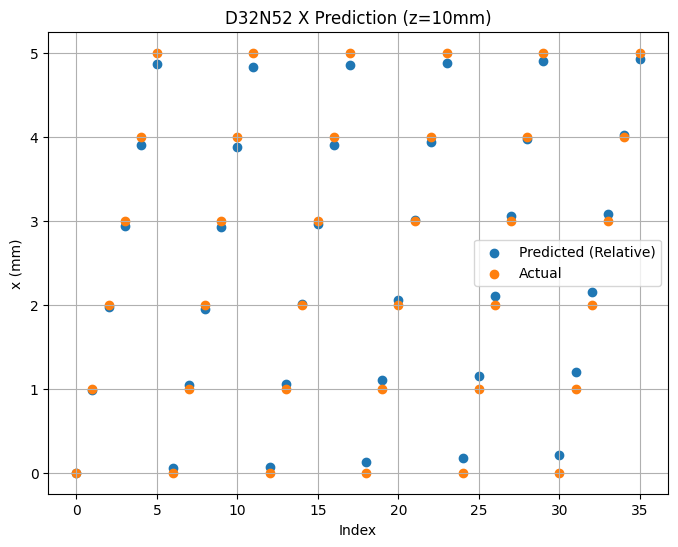

In [9]:
rel_loc_predx = [x - loc_pred[0,0] for x in loc_pred[:,0]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), rel_loc_predx, label='Predicted (Relative)')
plt.scatter(list(range(len(hdmm_x))), hdmm_y, label='Actual')
plt.xlabel('Index')
plt.ylabel('x (mm)')
plt.title('D32N52 X Prediction (z=10mm)')
plt.legend()
plt.grid(True)
plt.show()

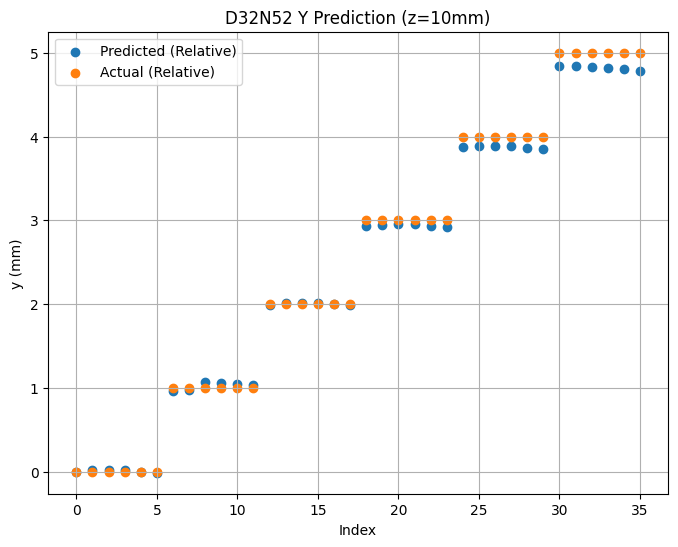

In [10]:
rel_loc_predy = [x - loc_pred[0,1] for x in loc_pred[:,1]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predy))), rel_loc_predy, label='Predicted (Relative)')
plt.scatter(list(range(len(hdmm_x))), hdmm_x, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('y (mm)')
plt.title('D32N52 Y Prediction (z=10mm)')
plt.legend()
plt.grid(True)
plt.show()

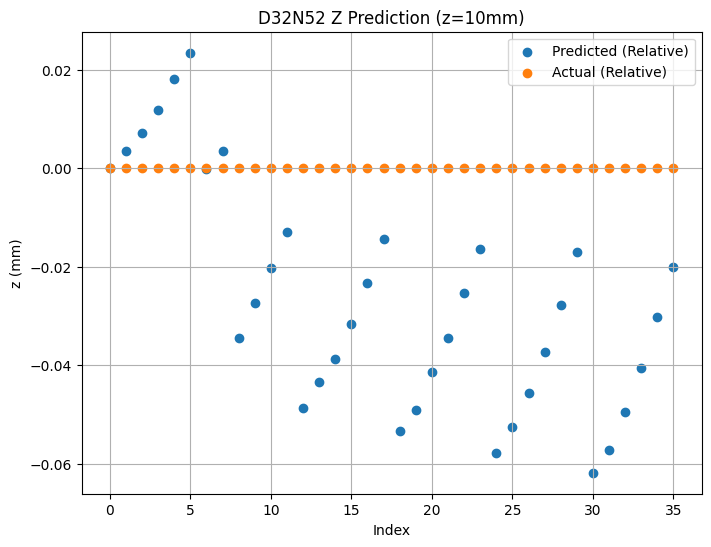

In [11]:
rel_loc_predz = [x - loc_pred[0,2] for x in loc_pred[:,2]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predz))), rel_loc_predz, label='Predicted (Relative)')
plt.scatter(list(range(len(hdmm_z))), hdmm_z, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('z (mm)')
plt.title('D32N52 Z Prediction (z=10mm)')
plt.legend()
plt.grid(True)
plt.show()

0.18531282454780396


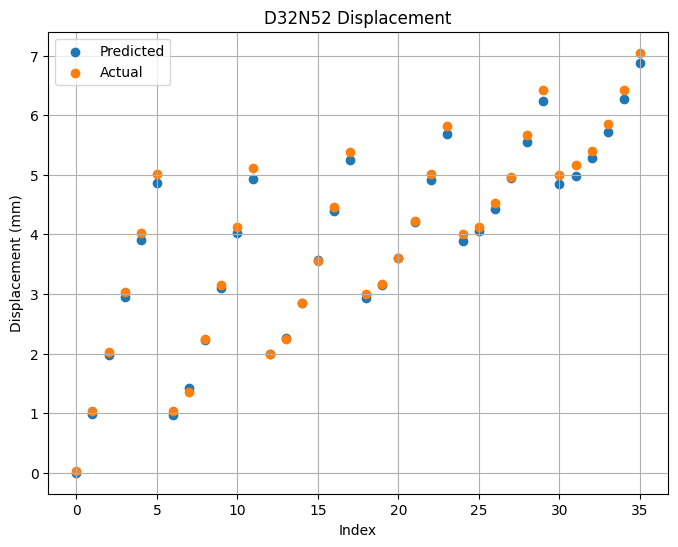

In [14]:
dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

diff = np.array(hdmm_disp) - disp
print(max(diff))

plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), disp, label='Predicted')
plt.scatter(list(range(len(hdmm_z))), hdmm_disp, label='Actual')
plt.xlabel('Index')
plt.ylabel('Displacement (mm)')
plt.title('D32N52 Displacement')
plt.legend()
plt.grid(True)
plt.show()